In [1]:
%load_ext autoreload

%autoreload 2

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
import pandas as pd
from sklearn.pipeline import Pipeline

In [2]:
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    mean = df.mean(axis=1)
    std = df.std(axis=1)
    mean_diff = df.subtract(mean, axis='index')
    return mean_diff.divide(std, axis='index')

In [3]:
LANDMARK_NAME = [
    "WRIST",
    "THUMB_CMC",
    "THUMB_MCP",
    "THUMB_IP",
    "THUMB_TIP",
    "INDEX_FINGER_MCP",
    "INDEX_FINGER_PIP",
    "INDEX_FINGER_DIP",
    "INDEX_FINGER_TIP",
    "MIDDLE_FINGER_MCP",
    "MIDDLE_FINGER_PIP",
    "MIDDLE_FINGER_DIP",
    "MIDDLE_FINGER_TIP",
    "RING_FINGER_MCP",
    "RING_FINGER_PIP",
    "RING_FINGER_DIP",
    "RING_FINGER_TIP",
    "PINKY_MCP",
    "PINKY_PIP",
    "PINKY_DIP",
    "PINKY_TIP"
]

LANDMARK_NAME_XYZ = [name + coordinate for name in LANDMARK_NAME for coordinate in ["_X", "_Y", "_Z"]]

In [4]:
# https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_set_output.html#sphx-glr-auto-examples-miscellaneous-plot-set-output-py
def create_preprocessing() -> Pipeline:
    """

    """
    frame_normalizer = ColumnTransformer(
        [
            ("x", FunctionTransformer(normalize, feature_names_out="one-to-one"),
             make_column_selector(pattern="_(?:x|X)$")),
            ("y", FunctionTransformer(normalize, feature_names_out="one-to-one"),
             make_column_selector(pattern="_(?:y|Y)$")),
            ("z", FunctionTransformer(normalize, feature_names_out="one-to-one"),
             make_column_selector(pattern="_(?:z|Z)$")),
        ],
        remainder='drop',
        verbose_feature_names_out=False
    )
    
    column_reorder = FunctionTransformer(
        lambda df: df[LANDMARK_NAME_XYZ], feature_names_out=lambda x,y: LANDMARK_NAME_XYZ
    )
    
    return Pipeline([
        ("normalize_frame", frame_normalizer),
        ("reorder_columns", column_reorder)
    ]).set_output(transform="pandas")

## Check KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier

preproc = create_preprocessing()
full_pipeline = Pipeline([("preproc", preproc), ("knn", KNeighborsClassifier())])

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("raw_data/images_ds.csv").dropna()
X = data.drop(columns = ["Unnamed: 0", "PATH", "TARGET"])
y = data["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

full_pipeline.fit(X_train, y_train_encoded)

display(full_pipeline.score(X_train, y_train_encoded))
display(full_pipeline.score(X_test, y_test_encoded))

0.9764031462471671

0.9594882729211087

In [74]:
data = pd.read_csv("raw_data/dataset-3.csv").dropna()
X = data.drop(columns = ["Unnamed: 0", "PATH", "TARGET"])
y = data["TARGET"]


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

full_pipeline.fit(X_train, y_train_encoded)

display(full_pipeline.score(X_train, y_train_encoded))
display(full_pipeline.score(X_test, y_test_encoded))

0.9837388490416399

0.976497012920854

In [7]:
knn = KNeighborsClassifier()

In [8]:
knn.fit(X_train, y_train_encoded)
display(knn.score(X_train, y_train_encoded))
display(knn.score(X_test, y_test_encoded))

0.9433408878816157

0.908315565031983

In [9]:
from sign_game.ml.landmarks import Landmarks

objc[8053]: Class CaptureDelegate is implemented in both /Users/cpsnowden/.pyenv/versions/3.10.6/envs/lewagon/envs/sign-game-server-working/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x177e28860) and /Users/cpsnowden/.pyenv/versions/3.10.6/envs/lewagon/envs/sign-game-server-working/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x2c0d625a0). One of the two will be used. Which one is undefined.
objc[8053]: Class CVWindow is implemented in both /Users/cpsnowden/.pyenv/versions/3.10.6/envs/lewagon/envs/sign-game-server-working/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x1488bca68) and /Users/cpsnowden/.pyenv/versions/3.10.6/envs/lewagon/envs/sign-game-server-working/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x2c0d625f0). One of the two will be used. Which one is undefined.
objc[8053]: Class CVView is implemented in both /Users/cpsnowden/.pyenv/versions/3.10.6/envs/lewagon/envs/sign-game-server-working/lib/python3.

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype=object)

In [10]:
import cv2
import matplotlib.pyplot as plt

def check_image(img):
    image = cv2.imread(img)
    cv2_img_w_landmarks, landmark_object = Landmarks().image_to_landmark(image, draw_landmarks=True)

    plt.imshow(cv2_img_w_landmarks);
    plt.show()

    img_lmks = pd.DataFrame([landmark_object])

    display(le.classes_[knn.predict(img_lmks)[0]])
    display(le.classes_[full_pipeline.predict(img_lmks)[0]])

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


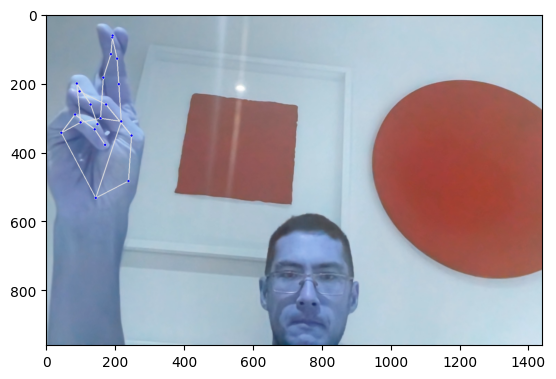

'K'

'U'

In [11]:
check_image('images/R-TopLeft.jpg')

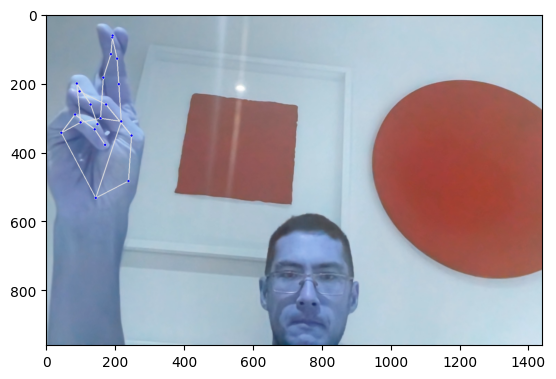

'U'

In [38]:
image = cv2.imread('images/R-TopLeft.jpg')

cv2_img_w_landmarks, landmark_object = Landmarks().image_to_landmark(image, draw_landmarks=True)

plt.imshow(cv2_img_w_landmarks);
plt.show()

img_lmks = pd.DataFrame([landmark_object])

knn.kneighbors(img_lmks, 1)

y_train[87957]

In [46]:
U = X_train.iloc[87957:87957+1, :]

In [47]:
from sign_game.ml.custom_landmark_plot import plot_landmarks_simple, handmarks_df_to_np

In [48]:
U_np = handmarks_df_to_np(U)

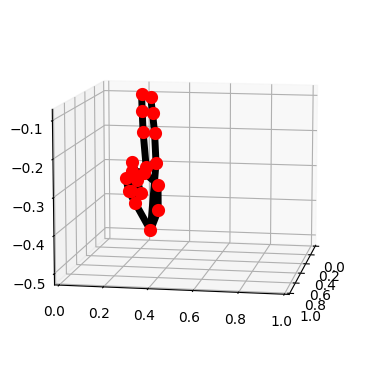

In [53]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(121, projection="3d")
ax1.set_xlim3d(left=0., right=1)
ax1.set_ylim3d(bottom=0., top=1) 
plot_landmarks_simple(ax1, U_np[0])

In [76]:
full_pipeline['knn'].kneighbors(img_lmks, 1)

(array([[1.40556772]]), array([[162642]]))

In [80]:
U = X_train.iloc[105472:105472+1, :]
UN =  preproc.transform(U)

In [90]:
# U.filter(like="_Z").mean(axis = 1)

82847   -0.050203
dtype: float64

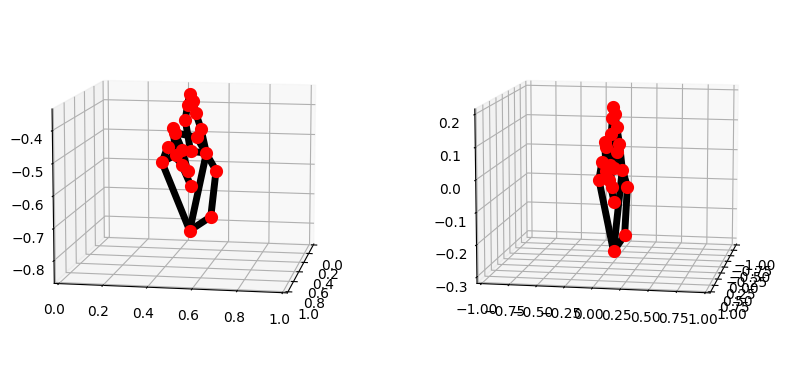

In [91]:
U = X_train.iloc[105472:105472+1, :]

U_np = handmarks_df_to_np(U)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221, projection="3d")
ax1.set_xlim3d(left=0., right=1)
ax1.set_ylim3d(bottom=0., top=1) 
plot_landmarks_simple(ax1, U_np[0])

U =  preproc.transform(U)
U_np = handmarks_df_to_np(U)
ax1 = fig.add_subplot(222, projection="3d")
ax1.set_xlim3d(left=-1., right=1)
ax1.set_ylim3d(bottom=-1., top=1) 
plot_landmarks_simple(ax1, U_np[0])

# U_np = handmarks_df_to_np(img_lmks)
# ax1 = fig.add_subplot(223, projection="3d")
# ax1.set_xlim3d(left=0., right=1)
# ax1.set_ylim3d(bottom=0., top=1) 
# plot_landmarks_simple(ax1, U_np[0])

# U =  preproc.transform(img_lmks)
# U_np = handmarks_df_to_np(U)
# fig = plt.figure(figsize=(10, 10))
# ax1 = fig.add_subplot(224, projection="3d")
# # ax1.set_xlim3d(left=0., right=1)
# # ax1.set_ylim3d(bottom=0., top=1) 
# plot_landmarks_simple(ax1, U_np[0])



In [61]:
data.loc[82847]

Unnamed: 0                                          82847
WRIST_X                                          0.409485
WRIST_Y                                          0.837057
WRIST_Z                                          0.000001
THUMB_CMC_X                                      0.522892
                                  ...                    
PINKY_TIP_X                                      0.435806
PINKY_TIP_Y                                      0.667763
PINKY_TIP_Z                                     -0.118157
TARGET                                                  U
PATH           ./asl_dataset_landmarks/U/pKXaldrBol-.jpeg
Name: 82847, Length: 66, dtype: object

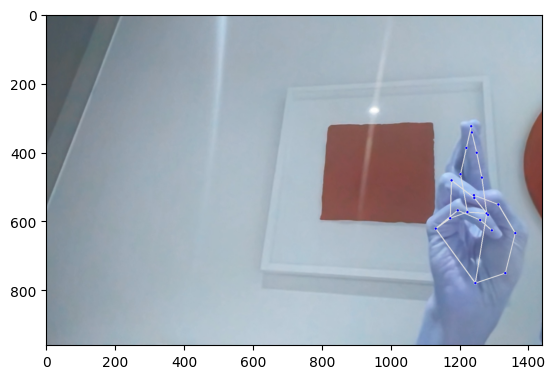

'U'

'U'

In [21]:
check_image('images/R-Right.jpg')

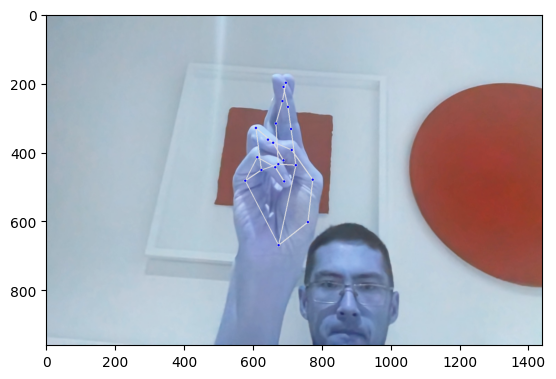

'K'

'R'

In [22]:
check_image('images/R-Middle.jpg')

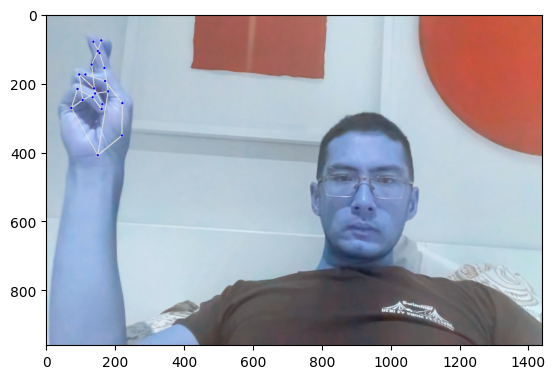

'U'

'U'

In [23]:
check_image('images/R-TopLeft2.jpg')

In [24]:
from sign_game.ml.evaluate import evaluate_model

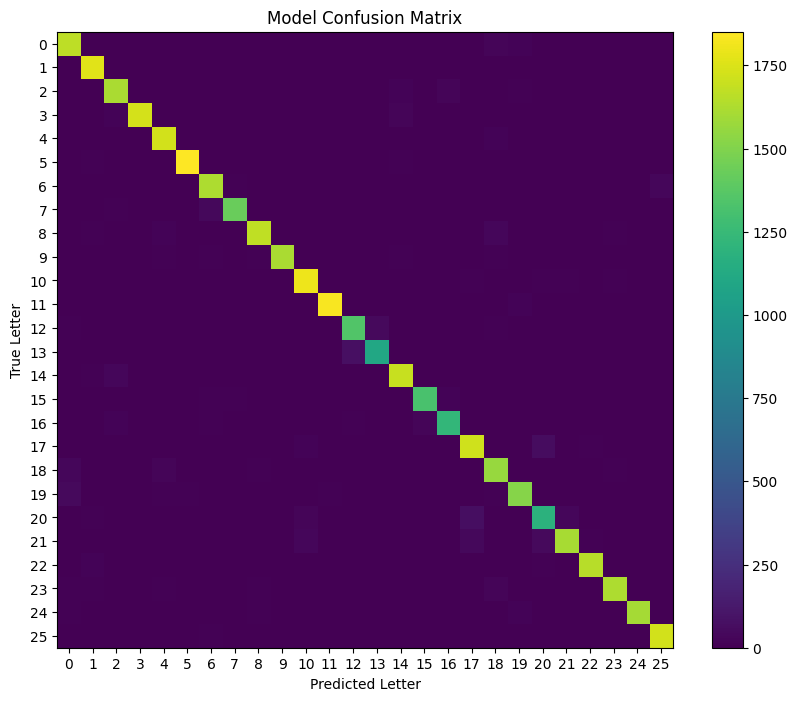

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1739
           1       0.94      0.99      0.97      1779
           2       0.94      0.96      0.95      1682
           3       0.99      0.97      0.98      1795
           4       0.94      0.97      0.96      1778
           5       0.98      0.98      0.98      1892
           6       0.95      0.96      0.95      1690
           7       0.98      0.95      0.96      1496
           8       0.97      0.94      0.96      1775
           9       0.98      0.95      0.97      1701
          10       0.96      0.97      0.96      1864
          11       0.98      0.98      0.98      1880
          12       0.93      0.94      0.94      1426
          13       0.94      0.92      0.93      1202
          14       0.95      0.96      0.96      1767
          15       0.97      0.97      0.97      1359
          16       0.96      0.94      0.95      1302
          17       0.93    

In [31]:
evaluate_model(y_test_encoded, knn.predict(X_test))

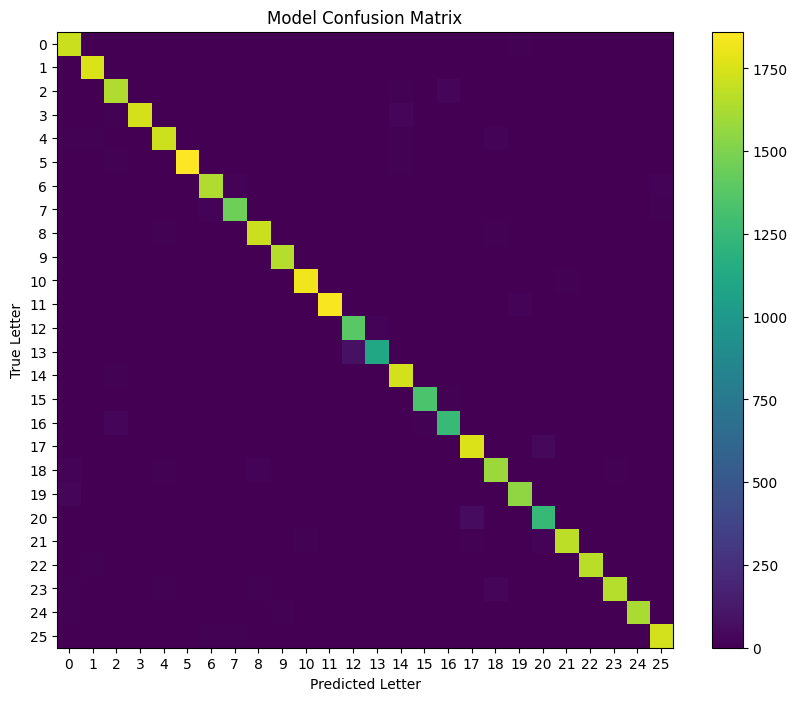

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1739
           1       0.97      0.99      0.98      1779
           2       0.95      0.97      0.96      1682
           3       0.99      0.97      0.98      1795
           4       0.96      0.97      0.97      1778
           5       0.99      0.98      0.99      1892
           6       0.97      0.97      0.97      1690
           7       0.97      0.97      0.97      1496
           8       0.98      0.96      0.97      1775
           9       0.97      0.97      0.97      1701
          10       0.99      0.98      0.98      1864
          11       0.99      0.98      0.98      1880
          12       0.93      0.97      0.95      1426
          13       0.98      0.92      0.95      1202
          14       0.95      0.98      0.97      1767
          15       0.98      0.98      0.98      1359
          16       0.96      0.96      0.96      1302
          17       0.96    

In [33]:
evaluate_model(y_test_encoded, full_pipeline.predict(X_test))

## Check CNN

In [154]:
# See how to plug Keras into a SKLearn Pipeline 
# https://towardsdatascience.com/are-you-using-the-scikit-learn-wrapper-in-your-keras-deep-learning-model-a3005696ff38
# https://www.adriangb.com/scikeras/stable/

In [164]:
data[data==].describe()

,Unnamed: 0,WRIST_X,WRIST_Y,WRIST_Z,THUMB_CMC_X,THUMB_CMC_Y,THUMB_CMC_Z,THUMB_MCP_X,THUMB_MCP_Y,THUMB_MCP_Z,...,PINKY_MCP_Z,PINKY_PIP_X,PINKY_PIP_Y,PINKY_PIP_Z,PINKY_DIP_X,PINKY_DIP_Y,PINKY_DIP_Z,PINKY_TIP_X,PINKY_TIP_Y,PINKY_TIP_Z
count,215929.000000,215929.000000,215929.000000,2.159290e+05,215929.000000,215929.000000,215929.000000,215929.000000,215929.000000,215929.000000,...,215929.000000,215929.000000,215929.000000,215929.000000,215929.000000,215929.000000,215929.000000,215929.000000,215929.000000,215929.000000
mean,126892.568002,0.490939,0.748654,8.271669e-08,0.480100,0.677524,-0.042509,0.481091,0.585371,-0.068736,...,-0.068686,0.558293,0.486916,-0.106040,0.551436,0.503770,-0.102130,0.546717,0.514862,-0.090648
std,75430.823239,0.168255,0.135630,9.622847e-07,0.157006,0.123577,0.053972,0.164254,0.117233,0.079761,...,0.073232,0.162892,0.137606,0.086854,0.160448,0.155858,0.089185,0.166965,0.179842,0.093011
min,0.000000,-0.031283,-0.035737,-2.768198e-06,0.009324,-0.003118,-0.365140,0.006728,0.059889,-0.539562,...,-0.642018,-0.076631,-0.008113,-0.797968,-0.058557,-0.010716,-0.875547,-0.055583,-0.013781,-0.939662
25%,61662.000000,0.382000,0.686421,-6.818988e-07,0.366614,0.605679,-0.064683,0.353302,0.508677,-0.098320,...,-0.091207,0.447324,0.386118,-0.136678,0.441276,0.381145,-0.132351,0.429374,0.376336,-0.121637
50%,125182.000000,0.510516,0.774709,-8.269646e-09,0.482160,0.691450,-0.043290,0.464694,0.589071,-0.065202,...,-0.057126,0.569584,0.484941,-0.094045,0.558331,0.514830,-0.090330,0.547224,0.536492,-0.077657
75%,193309.000000,0.610568,0.838870,8.477078e-07,0.595263,0.762307,-0.025446,0.604436,0.664416,-0.037858,...,-0.029527,0.674480,0.580396,-0.058747,0.667446,0.623059,-0.052884,0.669207,0.657068,-0.039224
max,259299.000000,1.051084,1.147349,5.417846e-06,1.038485,1.097452,0.287338,1.013597,0.970251,0.412699,...,0.553941,1.049330,1.094324,0.710573,1.073180,1.117656,0.732276,1.095235,1.128411,0.730311


In [ ]:
preproc.transform()